In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import sem
from scipy.stats import ranksums
from tqdm import tqdm

from active_learning import ActiveLearningLabeler, RandomSampler, UncertaintySampler, KMeansUncertaintySampler, EntropySampler, SelfTrainingSampler

### Set up MNIST dataset experiment

In [5]:
def get_mnist_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.reshape(len(X_train), 28, 28, 1).astype('float32') / 255
    X_test = X_test.reshape(len(X_test), 28, 28, 1).astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return X_train, X_test, y_test, y_train

def get_model():
    seed = 1
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model 

In [6]:
def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))


unlabeled, X_test, y_test, y_train = get_mnist_data()

sample_size=30
init_train_size=150
iters=30
repeat_n=30
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0)
model_params = {"epochs":100, "batch_size":128, "validation_split":0.3, "callbacks":[es], "verbose":0}

### Run experiment

Average with seeds

#### Random

In [ ]:
al = ActiveLearningLabeler(n_iters=iters, samplers=[RandomSampler(sample_size=sample_size)],
                           init_train_size=init_train_size)

random_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    random_metrics.append(accuracies)

#### Uncertainty

In [ ]:
al = ActiveLearningLabeler(n_iters=iters, samplers=[UncertaintySampler(sample_size=sample_size)],
                           init_train_size=init_train_size)

uncert_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    uncert_metrics.append(accuracies)

#### Entropy

In [ ]:
al = ActiveLearningLabeler(n_iters=iters, samplers=[EntropySampler(sample_size=sample_size)],
                           init_train_size=init_train_size)

entropy_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    entropy_metrics.append(accuracies)

#### KMeans

In [ ]:
al = ActiveLearningLabeler(n_iters=iters, samplers=[KMeansUncertaintySampler(sample_size=sample_size, n_clusters=10, flatten_data=True)],
                           init_train_size=init_train_size)

kmeans_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    kmeans_metrics.append(accuracies)

### Plot results

In [4]:
random_metrics = [[0.7598, 0.8005, 0.8129, 0.8282, 0.8596, 0.8611, 0.8725, 0.8776, 0.8781, 0.889, 0.8907, 0.8929, 0.8978, 0.9087, 0.8945, 0.913, 0.9139, 0.9092, 0.9203, 0.9244, 0.9266, 0.9262, 0.9265, 0.9334, 0.9347, 0.9372, 0.9403, 0.939, 0.94, 0.9437], [0.7687, 0.8042, 0.8071, 0.8504, 0.8738, 0.8784, 0.8713, 0.8929, 0.9011, 0.897, 0.9016, 0.9077, 0.9138, 0.9207, 0.9198, 0.9278, 0.9242, 0.928, 0.9358, 0.941, 0.9388, 0.9451, 0.9444, 0.9472, 0.9499, 0.9472, 0.9351, 0.9492, 0.9529, 0.9512], [0.7648, 0.8199, 0.8266, 0.8469, 0.846, 0.8605, 0.8721, 0.8911, 0.8915, 0.8997, 0.9054, 0.9031, 0.9096, 0.915, 0.9167, 0.9194, 0.9172, 0.9239, 0.9224, 0.9246, 0.9288, 0.9321, 0.9326, 0.9358, 0.9337, 0.9353, 0.9364, 0.9357, 0.9409, 0.9418], [0.7895, 0.8015, 0.8244, 0.8443, 0.8405, 0.8599, 0.8653, 0.8716, 0.8768, 0.882, 0.8852, 0.8914, 0.8979, 0.8977, 0.9013, 0.9101, 0.9164, 0.9146, 0.9217, 0.9264, 0.9337, 0.9354, 0.937, 0.9345, 0.9397, 0.9399, 0.9455, 0.9472, 0.9451, 0.9473], [0.7895, 0.8042, 0.7953, 0.82, 0.838, 0.8453, 0.8487, 0.8671, 0.8784, 0.8891, 0.8841, 0.8984, 0.9037, 0.9105, 0.915, 0.9115, 0.9201, 0.9216, 0.9292, 0.9314, 0.9296, 0.9316, 0.9371, 0.9378, 0.9342, 0.9377, 0.9378, 0.9394, 0.94, 0.9421], [0.7628, 0.7623, 0.775, 0.8333, 0.827, 0.8447, 0.8656, 0.8662, 0.8691, 0.8798, 0.8779, 0.8899, 0.8878, 0.8955, 0.9037, 0.9059, 0.9086, 0.9119, 0.9157, 0.9206, 0.9173, 0.9216, 0.9238, 0.9246, 0.9301, 0.9309, 0.9318, 0.9342, 0.9392, 0.9372], [0.7661, 0.7916, 0.8035, 0.824, 0.8524, 0.8486, 0.8539, 0.8633, 0.877, 0.8828, 0.8849, 0.8899, 0.8986, 0.8997, 0.9077, 0.9072, 0.9107, 0.9069, 0.9144, 0.91, 0.922, 0.923, 0.928, 0.9295, 0.9303, 0.9342, 0.9267, 0.9372, 0.9403, 0.9378], [0.76, 0.796, 0.8204, 0.8408, 0.845, 0.8573, 0.875, 0.8819, 0.8885, 0.896, 0.9055, 0.9036, 0.9035, 0.9125, 0.9096, 0.9287, 0.9251, 0.9258, 0.9329, 0.9344, 0.9348, 0.9374, 0.9391, 0.9417, 0.941, 0.9432, 0.9484, 0.9446, 0.9473, 0.9484], [0.7943, 0.7767, 0.8009, 0.8087, 0.8162, 0.8397, 0.8453, 0.8471, 0.8695, 0.8663, 0.8742, 0.886, 0.893, 0.8927, 0.8938, 0.9028, 0.9052, 0.9118, 0.9147, 0.9223, 0.9218, 0.9238, 0.9313, 0.9291, 0.9367, 0.9345, 0.9347, 0.9383, 0.9361, 0.9402], [0.7549, 0.7539, 0.7921, 0.8197, 0.8483, 0.8685, 0.8783, 0.8843, 0.8859, 0.8915, 0.8921, 0.8918, 0.8987, 0.8991, 0.9071, 0.9105, 0.918, 0.9208, 0.9244, 0.9273, 0.9286, 0.9345, 0.9333, 0.9362, 0.9376, 0.9396, 0.9379, 0.9343, 0.9426, 0.9497], [0.7648, 0.7771, 0.8109, 0.8299, 0.8536, 0.8488, 0.8529, 0.8663, 0.8668, 0.8755, 0.9004, 0.903, 0.9093, 0.9146, 0.9117, 0.9207, 0.9244, 0.9227, 0.9242, 0.9304, 0.9294, 0.9346, 0.9352, 0.9369, 0.9386, 0.9387, 0.9393, 0.9413, 0.9427, 0.9443], [0.7599, 0.7687, 0.7898, 0.8134, 0.8331, 0.8534, 0.8769, 0.8796, 0.8876, 0.8943, 0.8989, 0.9072, 0.91, 0.9094, 0.91, 0.9143, 0.9225, 0.9243, 0.9205, 0.9234, 0.9286, 0.9307, 0.9389, 0.9333, 0.9384, 0.941, 0.9385, 0.9424, 0.9421, 0.9464], [0.778, 0.7994, 0.809, 0.8292, 0.8476, 0.8495, 0.8624, 0.8784, 0.8846, 0.89, 0.9042, 0.9077, 0.9079, 0.916, 0.9248, 0.918, 0.9309, 0.931, 0.935, 0.9369, 0.9257, 0.9347, 0.9349, 0.936, 0.9384, 0.9352, 0.9411, 0.9415, 0.9413, 0.9433], [0.8047, 0.7952, 0.8272, 0.8334, 0.8538, 0.8463, 0.8534, 0.8667, 0.8718, 0.8808, 0.9024, 0.8985, 0.9069, 0.9133, 0.9124, 0.9191, 0.9199, 0.922, 0.9242, 0.9225, 0.9334, 0.9365, 0.9349, 0.9368, 0.9406, 0.9417, 0.9434, 0.9421, 0.9443, 0.9439], [0.7898, 0.8155, 0.822, 0.8355, 0.8521, 0.8559, 0.8635, 0.8672, 0.8673, 0.876, 0.8862, 0.8844, 0.8929, 0.8923, 0.9001, 0.904, 0.8983, 0.9047, 0.9092, 0.9077, 0.9128, 0.9177, 0.9196, 0.9233, 0.926, 0.9259, 0.9295, 0.9274, 0.93, 0.9318], [0.7912, 0.8115, 0.814, 0.8515, 0.8546, 0.8531, 0.8708, 0.8821, 0.8858, 0.8969, 0.8995, 0.9007, 0.9071, 0.915, 0.916, 0.918, 0.9231, 0.9243, 0.9263, 0.9284, 0.9272, 0.9325, 0.9362, 0.9371, 0.9412, 0.9419, 0.9424, 0.9449, 0.9436, 0.9455], [0.7794, 0.8007, 0.8196, 0.8297, 0.8401, 0.8402, 0.8525, 0.8649, 0.8802, 0.8934, 0.9039, 0.9077, 0.9163, 0.9174, 0.9204, 0.9217, 0.9235, 0.9294, 0.9312, 0.9331, 0.9341, 0.936, 0.9376, 0.9378, 0.9395, 0.9414, 0.9349, 0.9427, 0.9432, 0.9437], [0.7456, 0.7976, 0.8123, 0.8284, 0.8522, 0.8653, 0.8603, 0.879, 0.8628, 0.8794, 0.8984, 0.8984, 0.901, 0.8992, 0.9058, 0.9133, 0.9161, 0.9214, 0.9211, 0.9194, 0.9272, 0.9293, 0.9329, 0.939, 0.9387, 0.9438, 0.9448, 0.9429, 0.9452, 0.9396], [0.7421, 0.7917, 0.8101, 0.8271, 0.8333, 0.8437, 0.8531, 0.8676, 0.8797, 0.8812, 0.8869, 0.8916, 0.8903, 0.9016, 0.8842, 0.9031, 0.9045, 0.9049, 0.9075, 0.9107, 0.9132, 0.912, 0.9202, 0.9256, 0.9273, 0.9273, 0.9309, 0.9315, 0.9333, 0.9309], [0.7829, 0.7959, 0.8102, 0.8351, 0.8443, 0.8489, 0.8502, 0.8627, 0.8781, 0.8798, 0.8738, 0.8853, 0.8845, 0.894, 0.9023, 0.9128, 0.9171, 0.9241, 0.924, 0.9289, 0.9217, 0.9252, 0.9386, 0.9392, 0.9386, 0.9388, 0.9433, 0.9446, 0.9434, 0.9507], [0.7591, 0.7694, 0.8091, 0.8138, 0.815, 0.8276, 0.8419, 0.8425, 0.8605, 0.8697, 0.8906, 0.9009, 0.9125, 0.9142, 0.9151, 0.9271, 0.9241, 0.9286, 0.9313, 0.9371, 0.9353, 0.9357, 0.9341, 0.9438, 0.946, 0.9487, 0.9446, 0.95, 0.9471, 0.9494], [0.7898, 0.7975, 0.8209, 0.8454, 0.8526, 0.864, 0.8719, 0.8857, 0.8975, 0.907, 0.9019, 0.9076, 0.9155, 0.9215, 0.9094, 0.9258, 0.9274, 0.9298, 0.9345, 0.9333, 0.9372, 0.9357, 0.9372, 0.9436, 0.9431, 0.9453, 0.946, 0.9475, 0.948, 0.9494], [0.7698, 0.7726, 0.7941, 0.825, 0.8358, 0.8465, 0.8418, 0.844, 0.851, 0.8375, 0.8832, 0.8891, 0.8843, 0.897, 0.8945, 0.898, 0.9064, 0.9131, 0.9145, 0.9151, 0.9195, 0.9253, 0.9253, 0.9246, 0.9285, 0.9307, 0.9376, 0.9382, 0.9386, 0.9441], [0.7814, 0.8072, 0.7948, 0.8332, 0.857, 0.865, 0.8634, 0.874, 0.8768, 0.8901, 0.8952, 0.9034, 0.9033, 0.9139, 0.9243, 0.9241, 0.9293, 0.9294, 0.9347, 0.9338, 0.9256, 0.9362, 0.9346, 0.9323, 0.9375, 0.9393, 0.9381, 0.9421, 0.9475, 0.9485], [0.7813, 0.7954, 0.7893, 0.8126, 0.831, 0.8592, 0.8637, 0.8735, 0.8899, 0.8919, 0.8943, 0.897, 0.8961, 0.9122, 0.9046, 0.9147, 0.9241, 0.9262, 0.9249, 0.929, 0.9315, 0.9369, 0.9402, 0.9395, 0.9442, 0.9512, 0.9504, 0.9481, 0.9481, 0.9523], [0.7632, 0.7922, 0.7952, 0.8138, 0.853, 0.8562, 0.8668, 0.8719, 0.8824, 0.8773, 0.9011, 0.9039, 0.9046, 0.9046, 0.9153, 0.9168, 0.9177, 0.9274, 0.9238, 0.9279, 0.929, 0.9357, 0.9283, 0.9381, 0.9364, 0.9398, 0.9377, 0.9431, 0.9464, 0.9439], [0.7963, 0.8152, 0.8286, 0.86, 0.8676, 0.8706, 0.8846, 0.8851, 0.8897, 0.9042, 0.8973, 0.9145, 0.919, 0.925, 0.9215, 0.9291, 0.929, 0.9307, 0.9358, 0.938, 0.9401, 0.9418, 0.9441, 0.94, 0.9449, 0.9404, 0.9431, 0.9462, 0.9449, 0.9469], [0.7391, 0.7914, 0.8381, 0.8598, 0.8678, 0.8791, 0.8887, 0.8869, 0.8925, 0.8916, 0.8918, 0.9006, 0.9006, 0.9073, 0.9127, 0.9164, 0.9197, 0.9256, 0.93, 0.9309, 0.9276, 0.9288, 0.9331, 0.9386, 0.9381, 0.9389, 0.9285, 0.9409, 0.9428, 0.9433], [0.7658, 0.7872, 0.8235, 0.8403, 0.854, 0.8699, 0.8715, 0.8805, 0.8813, 0.8788, 0.8899, 0.9009, 0.9013, 0.9031, 0.9057, 0.9117, 0.918, 0.9231, 0.9268, 0.923, 0.9219, 0.9289, 0.9311, 0.9284, 0.9255, 0.9344, 0.9354, 0.9375, 0.9365, 0.94], [0.7694, 0.8064, 0.8107, 0.8235, 0.8597, 0.8718, 0.8816, 0.8958, 0.8951, 0.9031, 0.9121, 0.9132, 0.9175, 0.9169, 0.9155, 0.9231, 0.9272, 0.9299, 0.9353, 0.9324, 0.9354, 0.9379, 0.9389, 0.9384, 0.9409, 0.9438, 0.9387, 0.9456, 0.947, 0.9478]] 
uncert_metrics = [[0.7806, 0.7949, 0.8166, 0.8366, 0.8621, 0.8679, 0.8756, 0.8883, 0.8888, 0.8884, 0.8988, 0.9097, 0.9163, 0.922, 0.9293, 0.9295, 0.9333, 0.9443, 0.9464, 0.9501, 0.9519, 0.951, 0.9512, 0.9543, 0.9558, 0.9544, 0.9541, 0.9606, 0.962, 0.9616], [0.7558, 0.7748, 0.7697, 0.8143, 0.8377, 0.8389, 0.8563, 0.8665, 0.8871, 0.8886, 0.8983, 0.8995, 0.906, 0.9099, 0.9237, 0.9354, 0.9386, 0.9432, 0.9424, 0.9472, 0.951, 0.9554, 0.9556, 0.9593, 0.9593, 0.9616, 0.9601, 0.9578, 0.9667, 0.9659], [0.7602, 0.7893, 0.787, 0.819, 0.8302, 0.842, 0.8521, 0.859, 0.8592, 0.8878, 0.8981, 0.904, 0.9081, 0.9147, 0.9192, 0.9194, 0.9247, 0.9319, 0.9362, 0.9377, 0.9383, 0.9443, 0.9456, 0.9496, 0.9508, 0.9499, 0.9514, 0.955, 0.9549, 0.9626], [0.7783, 0.8105, 0.828, 0.8553, 0.8639, 0.8667, 0.8816, 0.8908, 0.8861, 0.9013, 0.9028, 0.914, 0.92, 0.92, 0.9211, 0.9317, 0.9403, 0.9427, 0.9463, 0.9468, 0.9469, 0.952, 0.9549, 0.9587, 0.9582, 0.9573, 0.9641, 0.963, 0.9675, 0.9703], [0.746, 0.7839, 0.8053, 0.8065, 0.8315, 0.8522, 0.8568, 0.8638, 0.8711, 0.8804, 0.8913, 0.8978, 0.9035, 0.9042, 0.9204, 0.9216, 0.9311, 0.9294, 0.9314, 0.9307, 0.94, 0.9356, 0.9417, 0.9427, 0.947, 0.9523, 0.9506, 0.9528, 0.9529, 0.9553], [0.7672, 0.8301, 0.8004, 0.8508, 0.8638, 0.8736, 0.8851, 0.8917, 0.8943, 0.9098, 0.9125, 0.925, 0.9271, 0.9359, 0.9332, 0.9424, 0.9468, 0.9499, 0.9503, 0.9511, 0.9522, 0.9491, 0.9549, 0.9609, 0.9624, 0.9581, 0.9608, 0.9607, 0.9615, 0.9634], [0.7739, 0.7825, 0.7886, 0.8174, 0.8279, 0.8457, 0.8515, 0.853, 0.8668, 0.8879, 0.8958, 0.9038, 0.9116, 0.9168, 0.9208, 0.9265, 0.9362, 0.9407, 0.9438, 0.9435, 0.9408, 0.9484, 0.9533, 0.9566, 0.954, 0.9565, 0.9615, 0.9586, 0.9661, 0.9667], [0.7377, 0.7848, 0.8135, 0.8415, 0.8568, 0.8641, 0.8782, 0.8926, 0.9008, 0.9118, 0.9195, 0.926, 0.9284, 0.9241, 0.9256, 0.9371, 0.9375, 0.9462, 0.9476, 0.9497, 0.9524, 0.9566, 0.957, 0.9598, 0.961, 0.961, 0.9604, 0.9622, 0.9666, 0.9678], [0.7748, 0.7914, 0.8056, 0.8299, 0.8456, 0.8572, 0.8611, 0.8717, 0.8881, 0.9001, 0.8993, 0.9083, 0.9137, 0.9238, 0.9289, 0.9292, 0.9323, 0.9415, 0.9437, 0.9472, 0.9488, 0.9515, 0.9536, 0.9569, 0.9581, 0.9591, 0.9612, 0.9628, 0.9617, 0.9657], [0.7854, 0.8094, 0.8212, 0.825, 0.8556, 0.8698, 0.8923, 0.9003, 0.8966, 0.9154, 0.9214, 0.9306, 0.9323, 0.9331, 0.9414, 0.9415, 0.9463, 0.9492, 0.9548, 0.955, 0.956, 0.9577, 0.9578, 0.956, 0.9581, 0.9641, 0.9668, 0.9673, 0.9655, 0.9695], [0.7814, 0.7966, 0.7792, 0.8455, 0.8515, 0.8644, 0.8749, 0.8894, 0.8887, 0.9008, 0.9104, 0.9065, 0.9179, 0.9272, 0.9199, 0.9287, 0.9424, 0.947, 0.9514, 0.949, 0.9528, 0.9498, 0.9605, 0.9602, 0.9653, 0.966, 0.9659, 0.9655, 0.9709, 0.9698], [0.7953, 0.7907, 0.8195, 0.8522, 0.8591, 0.8711, 0.8773, 0.8767, 0.8749, 0.8915, 0.8945, 0.9044, 0.9091, 0.9189, 0.9192, 0.9316, 0.9335, 0.939, 0.9397, 0.9438, 0.9456, 0.9457, 0.9525, 0.9573, 0.9578, 0.9629, 0.9616, 0.9594, 0.9638, 0.9628], [0.788, 0.7634, 0.7941, 0.8239, 0.8284, 0.859, 0.8809, 0.8942, 0.8912, 0.9085, 0.9171, 0.9171, 0.923, 0.9304, 0.9317, 0.9284, 0.9363, 0.9431, 0.9411, 0.948, 0.9485, 0.9534, 0.9597, 0.9606, 0.9615, 0.9627, 0.9582, 0.9637, 0.9656, 0.966], [0.7644, 0.8031, 0.8137, 0.8422, 0.8529, 0.874, 0.8821, 0.8947, 0.8926, 0.9176, 0.924, 0.9244, 0.9321, 0.9334, 0.9373, 0.9284, 0.9356, 0.9461, 0.9506, 0.9509, 0.9504, 0.9546, 0.9592, 0.9656, 0.9658, 0.9655, 0.9654, 0.9657, 0.968, 0.9694], [0.7369, 0.7794, 0.7943, 0.814, 0.825, 0.8389, 0.8563, 0.861, 0.8588, 0.8798, 0.8843, 0.8867, 0.9024, 0.9122, 0.9189, 0.9211, 0.923, 0.9343, 0.9364, 0.945, 0.9424, 0.9449, 0.9479, 0.9459, 0.948, 0.9483, 0.9505, 0.9562, 0.9547, 0.9589], [0.7611, 0.7655, 0.8075, 0.8305, 0.8578, 0.8618, 0.8792, 0.8875, 0.8892, 0.8919, 0.903, 0.9121, 0.9126, 0.9167, 0.9219, 0.9382, 0.9394, 0.9347, 0.9425, 0.9461, 0.9431, 0.9487, 0.9548, 0.9573, 0.9589, 0.9608, 0.9558, 0.9607, 0.9626, 0.9665], [0.7424, 0.7489, 0.7893, 0.8543, 0.8578, 0.8803, 0.8906, 0.898, 0.9131, 0.9151, 0.9222, 0.9306, 0.9314, 0.9291, 0.9364, 0.9446, 0.9474, 0.9456, 0.9496, 0.9528, 0.951, 0.9564, 0.9597, 0.9612, 0.9628, 0.9617, 0.9633, 0.9659, 0.9668, 0.9685], [0.7932, 0.8036, 0.8203, 0.8491, 0.8483, 0.8498, 0.8602, 0.8784, 0.8846, 0.8892, 0.8975, 0.918, 0.9148, 0.9227, 0.9135, 0.9314, 0.9349, 0.9342, 0.9411, 0.9428, 0.9454, 0.9508, 0.9547, 0.9598, 0.9587, 0.9603, 0.9624, 0.9618, 0.9644, 0.9659], [0.764, 0.7982, 0.8098, 0.8444, 0.8674, 0.8667, 0.8738, 0.8847, 0.9032, 0.9196, 0.9122, 0.9209, 0.9251, 0.9242, 0.9203, 0.9193, 0.9294, 0.9331, 0.9393, 0.9427, 0.9439, 0.9521, 0.9539, 0.956, 0.9589, 0.9588, 0.9617, 0.9659, 0.9681, 0.9699], [0.766, 0.7977, 0.8398, 0.8691, 0.8596, 0.8708, 0.8786, 0.8871, 0.8903, 0.8948, 0.9064, 0.9155, 0.9148, 0.9225, 0.9208, 0.9311, 0.9299, 0.937, 0.9391, 0.9422, 0.9363, 0.9468, 0.9424, 0.9455, 0.9489, 0.9461, 0.9522, 0.9572, 0.9582, 0.9561], [0.7571, 0.7736, 0.8205, 0.8349, 0.8382, 0.8625, 0.8753, 0.8834, 0.8806, 0.8931, 0.8963, 0.9032, 0.9169, 0.9219, 0.9226, 0.9318, 0.9407, 0.9464, 0.9468, 0.9452, 0.9476, 0.956, 0.9525, 0.9571, 0.9571, 0.9574, 0.9611, 0.9602, 0.9545, 0.9611], [0.7935, 0.8042, 0.8096, 0.8264, 0.8534, 0.867, 0.8766, 0.8935, 0.8851, 0.8992, 0.9082, 0.9154, 0.9027, 0.9126, 0.9201, 0.9194, 0.9302, 0.9375, 0.946, 0.9472, 0.9468, 0.9476, 0.9538, 0.9591, 0.9573, 0.9551, 0.9621, 0.9651, 0.9644, 0.9628], [0.7709, 0.7962, 0.8195, 0.8378, 0.857, 0.864, 0.8707, 0.888, 0.8883, 0.8987, 0.9131, 0.9182, 0.9168, 0.9334, 0.9323, 0.9345, 0.9374, 0.9422, 0.9465, 0.9467, 0.9435, 0.9454, 0.9503, 0.955, 0.9592, 0.9573, 0.9573, 0.9621, 0.9648, 0.9655], [0.7734, 0.7993, 0.8301, 0.8464, 0.8521, 0.8712, 0.8714, 0.8852, 0.8983, 0.9054, 0.9215, 0.9317, 0.9324, 0.9365, 0.9328, 0.9399, 0.9431, 0.948, 0.9476, 0.9531, 0.9534, 0.9567, 0.96, 0.9629, 0.9647, 0.9675, 0.9676, 0.9682, 0.9685, 0.9681], [0.7628, 0.7853, 0.7991, 0.8259, 0.8556, 0.8729, 0.8817, 0.8844, 0.8927, 0.8969, 0.9044, 0.9136, 0.9175, 0.921, 0.9214, 0.9317, 0.94, 0.945, 0.9498, 0.949, 0.9481, 0.9553, 0.9536, 0.9592, 0.9595, 0.966, 0.967, 0.969, 0.9717, 0.9705], [0.7736, 0.789, 0.8162, 0.8341, 0.8448, 0.869, 0.8795, 0.896, 0.9057, 0.9124, 0.9167, 0.9226, 0.9336, 0.9378, 0.9458, 0.9406, 0.9417, 0.9437, 0.9473, 0.9487, 0.945, 0.951, 0.9508, 0.9518, 0.958, 0.9582, 0.9588, 0.9567, 0.9615, 0.9654], [0.7566, 0.7997, 0.8038, 0.8219, 0.8267, 0.8341, 0.8521, 0.8803, 0.8869, 0.8984, 0.9093, 0.9144, 0.9256, 0.9283, 0.9245, 0.9341, 0.9373, 0.9421, 0.9451, 0.9475, 0.9497, 0.9513, 0.9531, 0.9566, 0.9601, 0.9607, 0.9587, 0.9616, 0.9672, 0.9695], [0.7588, 0.7722, 0.7946, 0.8151, 0.8198, 0.8451, 0.8521, 0.8684, 0.8686, 0.8755, 0.8962, 0.9009, 0.9097, 0.9088, 0.9109, 0.9287, 0.9355, 0.9443, 0.9453, 0.9475, 0.9442, 0.9515, 0.9523, 0.9554, 0.9593, 0.9594, 0.9603, 0.9606, 0.966, 0.9672], [0.7743, 0.8043, 0.8291, 0.8672, 0.8778, 0.8827, 0.8927, 0.9017, 0.8956, 0.9068, 0.9154, 0.9144, 0.9217, 0.9296, 0.9279, 0.9451, 0.9412, 0.9411, 0.9454, 0.9479, 0.9493, 0.9549, 0.9559, 0.9572, 0.9607, 0.9633, 0.9639, 0.9638, 0.9668, 0.9656], [0.7731, 0.7948, 0.8251, 0.8415, 0.8556, 0.8554, 0.862, 0.8871, 0.8867, 0.9078, 0.9137, 0.9176, 0.9215, 0.9242, 0.9256, 0.9254, 0.939, 0.9387, 0.9366, 0.9423, 0.9408, 0.9431, 0.9488, 0.9548, 0.956, 0.9566, 0.9592, 0.9592, 0.9588, 0.9613]]
entropy_metrics = [[0.7679, 0.8194, 0.7786, 0.8278, 0.8448, 0.8647, 0.8679, 0.8781, 0.8855, 0.8895, 0.8997, 0.9015, 0.9007, 0.9053, 0.9041, 0.9106, 0.9173, 0.9207, 0.9234, 0.9273, 0.9239, 0.9395, 0.9413, 0.9432, 0.9498, 0.9513, 0.9537, 0.9484, 0.9599, 0.9602], [0.8265, 0.8182, 0.835, 0.8579, 0.8726, 0.8783, 0.8861, 0.8941, 0.8897, 0.8985, 0.9028, 0.9069, 0.9065, 0.9055, 0.902, 0.9243, 0.9309, 0.9247, 0.9314, 0.933, 0.9337, 0.9392, 0.9477, 0.9423, 0.9428, 0.9481, 0.9496, 0.949, 0.9561, 0.9605], [0.7781, 0.805, 0.8343, 0.8309, 0.8435, 0.8359, 0.8381, 0.8756, 0.8844, 0.8826, 0.885, 0.893, 0.8998, 0.9106, 0.9118, 0.9213, 0.9267, 0.9308, 0.9324, 0.9328, 0.9376, 0.9366, 0.9433, 0.9501, 0.9511, 0.9518, 0.9523, 0.9513, 0.9567, 0.9569], [0.766, 0.7557, 0.7823, 0.8203, 0.8248, 0.8375, 0.8369, 0.8448, 0.8681, 0.8811, 0.8846, 0.9011, 0.9032, 0.9141, 0.9198, 0.9283, 0.9275, 0.9314, 0.9288, 0.9279, 0.933, 0.9383, 0.9363, 0.9412, 0.9444, 0.9497, 0.9518, 0.9531, 0.9593, 0.9616], [0.7085, 0.763, 0.8074, 0.8377, 0.8609, 0.8715, 0.8706, 0.8805, 0.8856, 0.8907, 0.9035, 0.908, 0.9162, 0.9188, 0.9177, 0.9275, 0.9252, 0.9299, 0.9368, 0.9396, 0.9432, 0.9458, 0.9456, 0.9495, 0.9506, 0.9526, 0.9513, 0.9537, 0.9554, 0.9563], [0.7899, 0.8139, 0.8348, 0.8638, 0.8585, 0.8653, 0.871, 0.8766, 0.883, 0.888, 0.8953, 0.9076, 0.9065, 0.9124, 0.9108, 0.9236, 0.9297, 0.937, 0.9428, 0.9413, 0.9467, 0.9467, 0.9447, 0.9441, 0.9476, 0.9509, 0.9415, 0.9485, 0.9557, 0.9586], [0.7855, 0.8015, 0.808, 0.8274, 0.8684, 0.8765, 0.8859, 0.897, 0.8978, 0.9032, 0.9068, 0.9116, 0.91, 0.924, 0.9054, 0.9204, 0.9329, 0.9305, 0.9382, 0.9432, 0.9442, 0.9456, 0.9483, 0.9511, 0.9505, 0.9565, 0.9545, 0.9508, 0.956, 0.9576], [0.7372, 0.7811, 0.798, 0.8236, 0.8392, 0.8515, 0.8514, 0.8715, 0.8778, 0.8945, 0.9085, 0.914, 0.9115, 0.9187, 0.9143, 0.9266, 0.9244, 0.9237, 0.9227, 0.9225, 0.9332, 0.9344, 0.9373, 0.9423, 0.941, 0.9503, 0.9518, 0.9564, 0.958, 0.9633], [0.7897, 0.837, 0.8428, 0.8581, 0.8668, 0.883, 0.8832, 0.8994, 0.9043, 0.9146, 0.9134, 0.9226, 0.9305, 0.932, 0.9317, 0.9401, 0.9369, 0.9392, 0.9413, 0.9417, 0.9475, 0.9526, 0.9523, 0.9547, 0.9587, 0.9616, 0.9641, 0.9637, 0.966, 0.9661], [0.7807, 0.8036, 0.8346, 0.8257, 0.8283, 0.8351, 0.8516, 0.8596, 0.8713, 0.8901, 0.8912, 0.8961, 0.9019, 0.9017, 0.904, 0.9071, 0.9095, 0.9214, 0.9278, 0.9313, 0.9324, 0.9368, 0.9386, 0.9454, 0.9463, 0.9486, 0.9528, 0.9558, 0.9583, 0.9627], [0.7587, 0.7807, 0.8233, 0.8512, 0.8647, 0.8764, 0.8818, 0.8914, 0.9012, 0.9134, 0.9197, 0.9254, 0.9337, 0.9332, 0.9367, 0.9366, 0.9437, 0.9446, 0.9521, 0.9511, 0.9511, 0.9526, 0.9541, 0.9596, 0.9602, 0.9624, 0.9589, 0.9664, 0.9696, 0.9674], [0.8028, 0.822, 0.8268, 0.852, 0.8707, 0.8754, 0.8743, 0.876, 0.8858, 0.8921, 0.8965, 0.9085, 0.9094, 0.9124, 0.9204, 0.9244, 0.9333, 0.9383, 0.943, 0.9464, 0.9487, 0.9478, 0.9507, 0.9575, 0.9577, 0.9591, 0.958, 0.9598, 0.96, 0.9588], [0.7894, 0.8079, 0.8253, 0.8602, 0.8568, 0.859, 0.8715, 0.8768, 0.8758, 0.8833, 0.8983, 0.9084, 0.9141, 0.9202, 0.9247, 0.9261, 0.9351, 0.9382, 0.941, 0.9406, 0.9362, 0.947, 0.9499, 0.9498, 0.9521, 0.9524, 0.9563, 0.9559, 0.9571, 0.9565], [0.7583, 0.7568, 0.8013, 0.8131, 0.8233, 0.8382, 0.853, 0.8516, 0.8618, 0.8874, 0.8973, 0.8998, 0.9101, 0.9137, 0.9179, 0.9266, 0.929, 0.9337, 0.9368, 0.937, 0.943, 0.9419, 0.9433, 0.9457, 0.9493, 0.9548, 0.9545, 0.9566, 0.9614, 0.9593], [0.793, 0.7983, 0.7961, 0.8388, 0.8379, 0.8429, 0.85, 0.863, 0.8642, 0.8675, 0.8905, 0.896, 0.8987, 0.9018, 0.9126, 0.9099, 0.9149, 0.9191, 0.9296, 0.9316, 0.9374, 0.9408, 0.9406, 0.9476, 0.9463, 0.9489, 0.9527, 0.9572, 0.9582, 0.9635], [0.6771, 0.7723, 0.7997, 0.8202, 0.8154, 0.8514, 0.8654, 0.8833, 0.8979, 0.9087, 0.9021, 0.9137, 0.9116, 0.9101, 0.9214, 0.9296, 0.9262, 0.9359, 0.9392, 0.934, 0.9311, 0.9446, 0.9452, 0.9435, 0.9462, 0.95, 0.9475, 0.9576, 0.9594, 0.9577], [0.7644, 0.8104, 0.8139, 0.8385, 0.8696, 0.8651, 0.8726, 0.871, 0.8558, 0.8654, 0.8913, 0.8938, 0.9028, 0.9106, 0.906, 0.9054, 0.9212, 0.932, 0.9314, 0.9371, 0.9391, 0.9429, 0.9409, 0.9451, 0.9507, 0.9481, 0.9512, 0.9513, 0.9545, 0.9555], [0.7757, 0.8029, 0.8076, 0.8366, 0.8381, 0.8531, 0.8614, 0.8722, 0.8861, 0.8924, 0.9051, 0.9094, 0.9131, 0.9163, 0.918, 0.933, 0.9383, 0.943, 0.9449, 0.9448, 0.9412, 0.9496, 0.9529, 0.9522, 0.956, 0.9581, 0.9551, 0.9546, 0.9551, 0.9553], [0.7723, 0.7784, 0.7962, 0.8193, 0.8421, 0.838, 0.851, 0.8652, 0.8781, 0.9005, 0.8935, 0.9125, 0.9083, 0.9103, 0.9158, 0.9204, 0.9249, 0.9317, 0.9293, 0.936, 0.9407, 0.9394, 0.946, 0.9464, 0.9493, 0.9496, 0.9432, 0.9576, 0.9541, 0.9573], [0.7855, 0.8108, 0.8165, 0.8272, 0.841, 0.8593, 0.8663, 0.8665, 0.884, 0.8884, 0.8994, 0.9026, 0.9126, 0.9156, 0.9251, 0.9235, 0.9317, 0.9311, 0.9361, 0.9456, 0.9438, 0.9456, 0.9501, 0.9524, 0.9554, 0.9536, 0.9551, 0.9558, 0.96, 0.9589], [0.7844, 0.7952, 0.8301, 0.8517, 0.8508, 0.8588, 0.8567, 0.8703, 0.8719, 0.8965, 0.9047, 0.9083, 0.925, 0.9238, 0.9328, 0.935, 0.9361, 0.9379, 0.9416, 0.9446, 0.9395, 0.9394, 0.948, 0.9529, 0.9559, 0.9602, 0.956, 0.9586, 0.9596, 0.9615], [0.7323, 0.7471, 0.7976, 0.8317, 0.846, 0.8488, 0.8618, 0.8579, 0.8806, 0.8856, 0.8907, 0.8971, 0.8845, 0.8933, 0.9001, 0.9097, 0.9167, 0.9229, 0.9231, 0.9265, 0.9275, 0.9411, 0.9454, 0.9436, 0.9536, 0.9576, 0.9493, 0.956, 0.9616, 0.9638], [0.7864, 0.8001, 0.8122, 0.8214, 0.8331, 0.8463, 0.8534, 0.8552, 0.8669, 0.8682, 0.8869, 0.8937, 0.8928, 0.8958, 0.9015, 0.9105, 0.9207, 0.9181, 0.9278, 0.9295, 0.9324, 0.9358, 0.9302, 0.9392, 0.9458, 0.9476, 0.9477, 0.9517, 0.952, 0.954], [0.7578, 0.7995, 0.8001, 0.8587, 0.8691, 0.866, 0.8762, 0.8727, 0.8916, 0.9047, 0.9027, 0.9219, 0.9251, 0.9239, 0.9243, 0.9311, 0.9321, 0.9388, 0.9443, 0.9365, 0.9409, 0.9475, 0.9504, 0.9501, 0.9506, 0.9532, 0.9493, 0.9539, 0.9596, 0.9588], [0.7786, 0.8055, 0.8038, 0.8355, 0.8522, 0.8508, 0.8684, 0.8816, 0.8999, 0.9047, 0.9075, 0.9126, 0.9122, 0.9177, 0.9112, 0.9261, 0.927, 0.923, 0.9294, 0.934, 0.9319, 0.9336, 0.9391, 0.9423, 0.9468, 0.948, 0.9464, 0.9487, 0.9525, 0.9536], [0.772, 0.8015, 0.8227, 0.8347, 0.8465, 0.8668, 0.871, 0.8818, 0.883, 0.8935, 0.8978, 0.9014, 0.9055, 0.91, 0.9196, 0.9196, 0.9191, 0.9288, 0.931, 0.9297, 0.9308, 0.9353, 0.9392, 0.9424, 0.9457, 0.9507, 0.9483, 0.9525, 0.9522, 0.9585], [0.7785, 0.7715, 0.7988, 0.8267, 0.8538, 0.8531, 0.8505, 0.8574, 0.8693, 0.8643, 0.8786, 0.8964, 0.9025, 0.8942, 0.9041, 0.9129, 0.9139, 0.9068, 0.9162, 0.9229, 0.9238, 0.9271, 0.9315, 0.9291, 0.9339, 0.9392, 0.9269, 0.9443, 0.9443, 0.9446], [0.7403, 0.7953, 0.8067, 0.8103, 0.8313, 0.8376, 0.854, 0.8556, 0.8655, 0.8676, 0.8858, 0.8949, 0.8941, 0.8966, 0.9071, 0.9139, 0.9186, 0.9235, 0.9321, 0.9395, 0.9395, 0.9383, 0.9398, 0.9464, 0.9498, 0.9506, 0.9526, 0.955, 0.9569, 0.9595], [0.8013, 0.8181, 0.8342, 0.8681, 0.8799, 0.8876, 0.8882, 0.8953, 0.8915, 0.9014, 0.9028, 0.9049, 0.9149, 0.9228, 0.9254, 0.9251, 0.9267, 0.937, 0.9438, 0.9472, 0.9455, 0.9508, 0.9537, 0.9549, 0.9534, 0.9568, 0.958, 0.9592, 0.9599, 0.9609], [0.7642, 0.7885, 0.8121, 0.8147, 0.8321, 0.8185, 0.8559, 0.8508, 0.8767, 0.8818, 0.8879, 0.8829, 0.893, 0.9053, 0.9093, 0.919, 0.9211, 0.9223, 0.9179, 0.9307, 0.9299, 0.9344, 0.941, 0.9472, 0.9457, 0.9457, 0.9453, 0.9529, 0.9535, 0.955]]
kmeans_metrics = [[0.7282, 0.7364, 0.7704, 0.8045, 0.8268, 0.8596, 0.867, 0.8762, 0.8876, 0.9048, 0.9126, 0.9168, 0.9246, 0.9306, 0.924, 0.9383, 0.9362, 0.9366, 0.9388, 0.9401, 0.9441, 0.9484, 0.9499, 0.9543, 0.9516, 0.9526, 0.9557, 0.9576, 0.9599, 0.9625], [0.7858, 0.8013, 0.8077, 0.8466, 0.869, 0.8757, 0.8922, 0.9044, 0.9125, 0.9213, 0.9269, 0.9319, 0.9381, 0.9437, 0.9431, 0.9474, 0.9506, 0.9512, 0.9486, 0.9536, 0.9546, 0.9571, 0.9567, 0.9614, 0.9656, 0.965, 0.9647, 0.9671, 0.9691, 0.967], [0.7467, 0.7692, 0.771, 0.8165, 0.8286, 0.8475, 0.855, 0.8788, 0.8933, 0.9031, 0.9136, 0.9217, 0.9263, 0.9312, 0.9324, 0.9336, 0.9437, 0.9451, 0.9482, 0.9485, 0.9519, 0.9512, 0.954, 0.9547, 0.9576, 0.963, 0.9669, 0.9674, 0.9704, 0.9696], [0.7666, 0.7937, 0.8056, 0.8453, 0.8637, 0.8802, 0.8832, 0.8882, 0.8937, 0.9134, 0.9182, 0.9227, 0.9276, 0.9334, 0.9366, 0.9419, 0.9423, 0.946, 0.948, 0.9482, 0.9512, 0.9505, 0.9507, 0.9525, 0.9563, 0.9607, 0.9586, 0.9645, 0.9621, 0.9661], [0.7724, 0.8135, 0.8204, 0.8522, 0.8747, 0.8852, 0.8917, 0.8953, 0.8995, 0.9168, 0.9251, 0.9297, 0.9415, 0.9452, 0.944, 0.947, 0.9529, 0.9555, 0.9549, 0.958, 0.959, 0.9609, 0.9637, 0.9657, 0.9624, 0.9639, 0.9705, 0.9694, 0.9684, 0.9691], [0.7762, 0.8022, 0.8235, 0.8359, 0.8552, 0.8744, 0.8855, 0.8942, 0.9082, 0.9134, 0.925, 0.9282, 0.9259, 0.9291, 0.9354, 0.9417, 0.9443, 0.9458, 0.9513, 0.9532, 0.9501, 0.9579, 0.962, 0.9639, 0.9652, 0.9637, 0.9635, 0.9678, 0.9652, 0.9676], [0.7871, 0.7915, 0.8011, 0.8391, 0.8456, 0.868, 0.8784, 0.8979, 0.9095, 0.909, 0.9114, 0.9273, 0.9356, 0.9372, 0.948, 0.9511, 0.948, 0.952, 0.9536, 0.957, 0.9529, 0.9607, 0.9631, 0.9635, 0.963, 0.965, 0.9608, 0.9652, 0.9683, 0.965], [0.8024, 0.8051, 0.8527, 0.8508, 0.8687, 0.8886, 0.8942, 0.898, 0.9005, 0.9146, 0.9219, 0.9242, 0.9333, 0.9365, 0.9412, 0.9478, 0.9488, 0.9506, 0.9561, 0.9545, 0.9542, 0.9576, 0.9611, 0.9627, 0.9618, 0.9573, 0.9604, 0.9626, 0.9625, 0.9668], [0.7852, 0.7906, 0.8047, 0.8373, 0.852, 0.8625, 0.864, 0.8806, 0.8922, 0.9017, 0.9214, 0.922, 0.924, 0.9302, 0.9304, 0.9332, 0.9411, 0.9427, 0.9423, 0.9472, 0.9525, 0.9554, 0.9587, 0.9596, 0.961, 0.9626, 0.9615, 0.9656, 0.9683, 0.9702], [0.7482, 0.7657, 0.7931, 0.8278, 0.8462, 0.8604, 0.8836, 0.8813, 0.9017, 0.9132, 0.9187, 0.926, 0.931, 0.9336, 0.9345, 0.9443, 0.9481, 0.9484, 0.9517, 0.9509, 0.9567, 0.9576, 0.9575, 0.9596, 0.9621, 0.9632, 0.9608, 0.9607, 0.9646, 0.9707], [0.7649, 0.7945, 0.7992, 0.8343, 0.857, 0.8712, 0.8834, 0.8883, 0.8916, 0.8972, 0.9101, 0.9166, 0.9271, 0.927, 0.932, 0.9377, 0.9408, 0.9372, 0.9433, 0.9486, 0.9531, 0.9486, 0.9593, 0.9607, 0.9627, 0.9636, 0.9655, 0.9677, 0.9675, 0.9696], [0.7727, 0.7839, 0.803, 0.8334, 0.861, 0.8857, 0.8903, 0.9032, 0.9114, 0.9207, 0.9246, 0.9262, 0.9335, 0.9386, 0.9335, 0.9375, 0.9473, 0.9474, 0.945, 0.9465, 0.9382, 0.9519, 0.9533, 0.9574, 0.9586, 0.9543, 0.956, 0.9628, 0.9651, 0.9673], [0.7562, 0.7601, 0.7799, 0.808, 0.8627, 0.8757, 0.8868, 0.9021, 0.9137, 0.9195, 0.9224, 0.9243, 0.9315, 0.941, 0.9362, 0.943, 0.9477, 0.9476, 0.9501, 0.9541, 0.9505, 0.9547, 0.9582, 0.9596, 0.9612, 0.9633, 0.9661, 0.9647, 0.9686, 0.9685], [0.7476, 0.7871, 0.8095, 0.8369, 0.8444, 0.8753, 0.883, 0.8924, 0.9075, 0.9168, 0.9198, 0.9235, 0.9273, 0.9349, 0.9312, 0.9386, 0.943, 0.9457, 0.9516, 0.9508, 0.9547, 0.9566, 0.9612, 0.9598, 0.9597, 0.9602, 0.962, 0.9663, 0.9676, 0.9703], [0.7804, 0.8143, 0.8408, 0.8551, 0.8723, 0.8745, 0.8792, 0.8953, 0.9104, 0.9158, 0.922, 0.9261, 0.9337, 0.9307, 0.932, 0.9335, 0.9395, 0.9416, 0.9456, 0.9543, 0.956, 0.9549, 0.9608, 0.964, 0.9625, 0.9633, 0.964, 0.966, 0.9673, 0.968], [0.774, 0.7957, 0.8279, 0.843, 0.85, 0.8743, 0.8844, 0.8899, 0.8882, 0.9061, 0.9128, 0.9157, 0.9219, 0.9378, 0.9396, 0.9482, 0.9512, 0.953, 0.9526, 0.958, 0.957, 0.9603, 0.9642, 0.9636, 0.9672, 0.967, 0.9665, 0.9673, 0.9683, 0.9671], [0.8067, 0.7921, 0.8184, 0.867, 0.8781, 0.8922, 0.8927, 0.9077, 0.9117, 0.9218, 0.9205, 0.9279, 0.9305, 0.9409, 0.9432, 0.9432, 0.9484, 0.949, 0.9522, 0.9544, 0.9553, 0.9602, 0.96, 0.9604, 0.9622, 0.9633, 0.969, 0.9678, 0.9684, 0.9685], [0.7735, 0.8088, 0.7929, 0.8408, 0.8414, 0.8736, 0.879, 0.8886, 0.9016, 0.9059, 0.9162, 0.9211, 0.9153, 0.9205, 0.9249, 0.9351, 0.9348, 0.9421, 0.9429, 0.9515, 0.9469, 0.9515, 0.9589, 0.961, 0.9579, 0.9591, 0.9612, 0.9662, 0.9645, 0.9677], [0.6934, 0.781, 0.826, 0.8422, 0.8568, 0.872, 0.8741, 0.8805, 0.8891, 0.8988, 0.9124, 0.9216, 0.9265, 0.9247, 0.9339, 0.9411, 0.9456, 0.9453, 0.9487, 0.9512, 0.9522, 0.949, 0.9549, 0.9543, 0.9577, 0.9586, 0.9603, 0.96, 0.9583, 0.9607], [0.7914, 0.8195, 0.8258, 0.8545, 0.8815, 0.8838, 0.8914, 0.8979, 0.9007, 0.9101, 0.9199, 0.9252, 0.9307, 0.93, 0.9405, 0.9468, 0.9501, 0.9548, 0.9578, 0.9582, 0.9576, 0.9554, 0.9617, 0.9619, 0.9614, 0.9662, 0.9656, 0.9665, 0.9693, 0.9696], [0.7535, 0.7735, 0.7613, 0.8311, 0.8582, 0.8523, 0.8767, 0.8822, 0.9, 0.9077, 0.9145, 0.9158, 0.9209, 0.9302, 0.9363, 0.9408, 0.9488, 0.9489, 0.9515, 0.9553, 0.9595, 0.9572, 0.9595, 0.9603, 0.9641, 0.9664, 0.9673, 0.9653, 0.9681, 0.9718], [0.7471, 0.7681, 0.7928, 0.8356, 0.863, 0.8766, 0.8883, 0.9019, 0.8967, 0.9131, 0.9193, 0.9221, 0.9251, 0.9325, 0.9407, 0.9426, 0.9491, 0.9453, 0.9517, 0.9572, 0.9516, 0.9575, 0.9575, 0.9648, 0.9634, 0.965, 0.9616, 0.9642, 0.9683, 0.97], [0.774, 0.7993, 0.8071, 0.8433, 0.8423, 0.8651, 0.8782, 0.8871, 0.8763, 0.9003, 0.9035, 0.9189, 0.9259, 0.931, 0.9361, 0.9376, 0.9373, 0.9412, 0.9508, 0.9537, 0.955, 0.9617, 0.963, 0.964, 0.9656, 0.968, 0.9695, 0.9702, 0.9694, 0.9725], [0.7626, 0.7591, 0.8384, 0.8463, 0.862, 0.8832, 0.8753, 0.8949, 0.9028, 0.9088, 0.9226, 0.92, 0.9315, 0.9373, 0.9324, 0.9418, 0.9473, 0.9503, 0.9501, 0.9513, 0.9524, 0.9556, 0.958, 0.9614, 0.961, 0.9653, 0.9682, 0.9678, 0.9695, 0.9721], [0.7477, 0.7809, 0.7961, 0.8241, 0.8439, 0.8728, 0.8777, 0.8801, 0.8923, 0.9142, 0.9187, 0.9219, 0.9274, 0.9308, 0.9283, 0.9378, 0.9428, 0.944, 0.9442, 0.948, 0.9523, 0.9526, 0.9605, 0.9585, 0.9594, 0.959, 0.9623, 0.9642, 0.9652, 0.9673], [0.7772, 0.8083, 0.8294, 0.8417, 0.8488, 0.8711, 0.8756, 0.883, 0.8966, 0.9077, 0.9204, 0.9259, 0.9248, 0.9314, 0.9331, 0.9369, 0.9417, 0.9496, 0.9486, 0.9534, 0.9594, 0.9562, 0.9613, 0.9571, 0.959, 0.9631, 0.9594, 0.9678, 0.9689, 0.968], [0.7407, 0.7812, 0.7861, 0.829, 0.8519, 0.8546, 0.8821, 0.8889, 0.8896, 0.9003, 0.9053, 0.9009, 0.9123, 0.9265, 0.9188, 0.9231, 0.9335, 0.9393, 0.9435, 0.9435, 0.9415, 0.9522, 0.9562, 0.9597, 0.9595, 0.9609, 0.9631, 0.9615, 0.9645, 0.9665], [0.7452, 0.8102, 0.813, 0.8396, 0.8763, 0.8779, 0.8909, 0.8923, 0.9041, 0.9118, 0.9226, 0.9266, 0.9317, 0.9316, 0.9317, 0.9278, 0.9396, 0.9474, 0.9521, 0.9523, 0.9568, 0.9589, 0.9585, 0.9625, 0.9641, 0.9642, 0.9675, 0.9677, 0.9696, 0.9713], [0.81, 0.8374, 0.8454, 0.8428, 0.8787, 0.8873, 0.8962, 0.9086, 0.9003, 0.9059, 0.9196, 0.9241, 0.9327, 0.94, 0.9395, 0.9401, 0.9484, 0.9503, 0.9546, 0.9545, 0.9516, 0.9583, 0.9593, 0.9631, 0.9634, 0.9644, 0.9618, 0.9636, 0.9681, 0.9664], [0.7916, 0.7977, 0.8149, 0.8449, 0.8567, 0.8609, 0.8748, 0.8963, 0.8956, 0.9101, 0.9224, 0.9267, 0.9275, 0.9321, 0.9445, 0.9449, 0.9489, 0.9525, 0.9499, 0.9562, 0.9588, 0.9602, 0.9629, 0.9654, 0.9648, 0.9668, 0.9654, 0.9698, 0.9711, 0.9725]]

[]

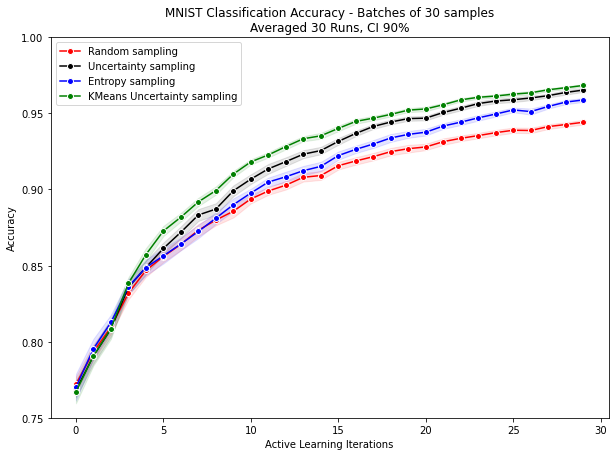

In [10]:
fig = plt.figure(figsize=(10,7))

random_mean = np.mean(random_metrics, axis=0)
uncert_mean = np.mean(uncert_metrics, axis=0)
entropy_mean = np.mean(entropy_metrics, axis=0)
kmeans_mean = np.mean(kmeans_metrics, axis=0) 


plt.plot(random_mean, c="red", marker="o", markersize=6, markeredgecolor="white", label="Random sampling")
plt.plot(uncert_mean, c="black", marker="o", markersize=6, markeredgecolor="white", label="Uncertainty sampling")
plt.plot(entropy_mean, c="blue", marker="o", markersize=6, markeredgecolor="white", label="Entropy sampling")
plt.plot(kmeans_mean, c="green", marker="o", markersize=6, markeredgecolor="white", label="KMeans Uncertainty sampling")

zscore_90_confidence = 1.65
random_ci = sem(random_metrics) * zscore_90_confidence
plt.fill_between(range(len(random_mean)), (random_mean-random_ci), (random_mean+random_ci), color='red', alpha=0.1)
uncert_ci = sem(uncert_metrics) * zscore_90_confidence
plt.fill_between(range(len(uncert_mean)), (uncert_mean-uncert_ci),(uncert_mean+uncert_ci), color='black', alpha=0.1)
entropy_ci = sem(entropy_metrics) * zscore_90_confidence
plt.fill_between(range(len(entropy_mean)), (entropy_mean-entropy_ci),(entropy_mean+entropy_ci), color='blue', alpha=0.1)
kmeans_ci = sem(kmeans_metrics) * zscore_90_confidence
plt.fill_between(range(len(kmeans_mean)), (kmeans_mean-kmeans_ci),(kmeans_mean+kmeans_ci), color='green', alpha=0.1)

plt.title(f"MNIST Classification Accuracy - Batches of {sample_size} samples\nAveraged {repeat_n} Runs, CI 90%")
plt.ylim((0.75, 1))
plt.xlabel("Active Learning Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.plot()

### Results significance

In [11]:
ranksums(random_mean, uncert_mean, alternative="less")

RanksumsResult(statistic=-1.7889154757100663, pvalue=0.03681421453264484)

In [12]:
ranksums(random_mean, entropy_mean, alternative="less")

RanksumsResult(statistic=-1.0201253539173105, pvalue=0.15383450685398742)

In [13]:
ranksums(random_mean, kmeans_mean, alternative="less")

RanksumsResult(statistic=-2.4098613433119076, pvalue=0.007979292130633106)

---
## Comparing Self-Learning

In [13]:
def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))


unlabeled, X_test, y_test, y_train = get_mnist_data()

sample_size=30
init_train_size=150
iters=30
repeat_n=30
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0)
model_params = {"epochs":100, "batch_size":128, "validation_split":0.3, "callbacks":[es], "verbose":0}

In [14]:
n_sample = len(y_test)
idx_sample = np.random.choice(len(unlabeled), size=n_sample, replace=False)
unlabeled, y_train = unlabeled[idx_sample], y_train[idx_sample]

In [ ]:
al = ActiveLearningLabeler(n_iters=iters, samplers=[UncertaintySampler(sample_size=sample_size)],
                           init_train_size=init_train_size)

uncert_metrics2 = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    uncert_metrics2.append(accuracies)

In [ ]:
self_training_threshold = 0.99
al = ActiveLearningLabeler(n_iters=iters, samplers=[UncertaintySampler(sample_size=sample_size),
                                                    SelfTrainingSampler(threshold=self_training_threshold)],
                           init_train_size=init_train_size)

uncert_self_training99_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    uncert_self_training99_metrics.append(accuracies)

In [ ]:
self_training_threshold = 0.95
al = ActiveLearningLabeler(n_iters=iters, samplers=[UncertaintySampler(sample_size=sample_size),
                                                    SelfTrainingSampler(threshold=self_training_threshold)],
                           init_train_size=init_train_size)

uncert_self_training95_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    uncert_self_training95_metrics.append(accuracies)

In [ ]:
self_training_threshold = 0.90
al = ActiveLearningLabeler(n_iters=iters, samplers=[UncertaintySampler(sample_size=sample_size),
                                                    SelfTrainingSampler(threshold=self_training_threshold)],
                           init_train_size=init_train_size)

uncert_self_training90_metrics = []
for n in tqdm(range(repeat_n)):
    model = get_model()
    accuracies = al.label(unlabeled=unlabeled, model=model, X_test=X_test, y_test=y_test, labels=y_train,
                         eval_function=eval_model, model_params=model_params)
    uncert_self_training90_metrics.append(accuracies)

In [16]:
uncert_self_training99_metrics = [[0.7977, 0.8244, 0.8147, 0.8553, 0.8634, 0.8644, 0.9023, 0.9069, 0.91, 0.9108, 0.9114, 0.9182, 0.9154, 0.9162, 0.919, 0.922, 0.9173], [0.7836, 0.7783, 0.8495, 0.8445, 0.8774, 0.8897, 0.9302, 0.9341, 0.9371, 0.9311, 0.9339, 0.9394, 0.9352, 0.9389, 0.9377, 0.9341, 0.9407], [0.7502, 0.768, 0.7978, 0.8232, 0.8379, 0.8405, 0.882, 0.8793, 0.8781, 0.8871, 0.8884, 0.8796, 0.8976, 0.9017, 0.8979, 0.9018, 0.8948], [0.7346, 0.7328, 0.7659, 0.7976, 0.8408, 0.8563, 0.8986, 0.9022, 0.9013, 0.9025, 0.9038, 0.9003, 0.9076, 0.9071, 0.9038, 0.9066, 0.9101], [0.7668, 0.7791, 0.8136, 0.8241, 0.8444, 0.8633, 0.902, 0.9054, 0.9055, 0.9052, 0.9071, 0.9096, 0.9073, 0.9091, 0.9083, 0.9068], [0.7823, 0.8174, 0.8342, 0.8771, 0.8902, 0.8975, 0.9302, 0.9327, 0.9348, 0.9404, 0.935, 0.9356, 0.9389, 0.9411, 0.9381, 0.9393], [0.7794, 0.7891, 0.8105, 0.8473, 0.8636, 0.868, 0.9235, 0.9305, 0.9319, 0.935, 0.938, 0.9355, 0.9403, 0.9395, 0.9428], [0.7802, 0.7989, 0.8181, 0.8428, 0.8692, 0.8801, 0.9136, 0.9194, 0.924, 0.9266, 0.9304, 0.9327, 0.9321, 0.9329, 0.93, 0.9323], [0.7027, 0.7628, 0.7658, 0.8189, 0.8334, 0.8342, 0.8772, 0.8932, 0.8922, 0.8927, 0.8886, 0.8885, 0.8797, 0.885, 0.8908, 0.8937, 0.8887, 0.8891], [0.7619, 0.7805, 0.8267, 0.8568, 0.8634, 0.8611, 0.9148, 0.9148, 0.9098, 0.9072, 0.9096, 0.9131, 0.9106, 0.9122, 0.9157, 0.9217, 0.9227], [0.755, 0.7817, 0.8314, 0.8365, 0.8456, 0.8639, 0.9106, 0.9091, 0.9078, 0.9088, 0.9085, 0.9086, 0.9187, 0.9142, 0.9082, 0.9169, 0.9179], [0.7703, 0.7739, 0.8137, 0.8312, 0.8511, 0.8564, 0.8972, 0.9001, 0.894, 0.9025, 0.9012, 0.9112, 0.9138, 0.9075, 0.917, 0.9147], [0.8002, 0.8082, 0.8334, 0.8603, 0.873, 0.8811, 0.9259, 0.9333, 0.926, 0.9314, 0.9426, 0.9437, 0.9425, 0.9428, 0.9459], [0.8, 0.8163, 0.8504, 0.8759, 0.887, 0.8854, 0.9199, 0.9247, 0.9249, 0.9249, 0.9215, 0.9257, 0.9317, 0.9347, 0.9329, 0.9338, 0.931], [0.7726, 0.8007, 0.8125, 0.8344, 0.8573, 0.8672, 0.916, 0.9186, 0.9149, 0.9159, 0.9216, 0.9212, 0.9246, 0.9147, 0.9225, 0.9213, 0.9244], [0.7805, 0.8176, 0.8403, 0.853, 0.8632, 0.8811, 0.9296, 0.9251, 0.9304, 0.9279, 0.9281, 0.9365, 0.9378, 0.9388, 0.94, 0.9389], [0.7835, 0.8123, 0.8087, 0.8462, 0.8726, 0.8764, 0.9206, 0.9164, 0.9245, 0.9264, 0.9325, 0.9299, 0.932, 0.9338, 0.9373, 0.9375, 0.9336], [0.7815, 0.8033, 0.831, 0.8529, 0.8773, 0.8702, 0.9051, 0.9167, 0.9079, 0.9178, 0.9167, 0.9176, 0.9198, 0.9097, 0.92, 0.9202, 0.9198], [0.7682, 0.7626, 0.7903, 0.8356, 0.8485, 0.8648, 0.9141, 0.9195, 0.9205, 0.9212, 0.9202, 0.9216, 0.9162, 0.9235, 0.9241, 0.9169, 0.924], [0.7843, 0.7827, 0.8342, 0.8575, 0.8471, 0.8737, 0.9097, 0.9204, 0.9222, 0.9183, 0.9191, 0.9284, 0.9265, 0.9269, 0.9264, 0.9143], [0.7817, 0.8015, 0.8212, 0.838, 0.8575, 0.8797, 0.9104, 0.9165, 0.9145, 0.9159, 0.9149, 0.9238, 0.9209, 0.9257, 0.9189, 0.9189], [0.7728, 0.8154, 0.8239, 0.8349, 0.8625, 0.8711, 0.917, 0.9177, 0.9211, 0.9169, 0.9193, 0.9279, 0.9264, 0.9317, 0.9311, 0.9315], [0.7968, 0.8101, 0.8545, 0.8767, 0.8778, 0.8933, 0.9331, 0.9371, 0.9313, 0.9375, 0.9397, 0.942, 0.9406, 0.9436, 0.9417, 0.9462], [0.7872, 0.8181, 0.8338, 0.8655, 0.8791, 0.8799, 0.9243, 0.9276, 0.9223, 0.9315, 0.9349, 0.9408, 0.9384, 0.9402, 0.9442, 0.9433], [0.7662, 0.7668, 0.811, 0.8313, 0.8578, 0.8699, 0.9178, 0.9215, 0.9174, 0.9223, 0.921, 0.925, 0.929, 0.9302, 0.935, 0.9318], [0.7782, 0.8269, 0.8255, 0.8442, 0.867, 0.8825, 0.9177, 0.9203, 0.9282, 0.9252, 0.9267, 0.9272, 0.9233, 0.9248, 0.9285, 0.9284], [0.7455, 0.7672, 0.7586, 0.8237, 0.8334, 0.8703, 0.9086, 0.9156, 0.9113, 0.9124, 0.9075, 0.9095, 0.9144, 0.9239, 0.9221, 0.9232, 0.9191], [0.7672, 0.7734, 0.8011, 0.8351, 0.8504, 0.8684, 0.9171, 0.9205, 0.9198, 0.9195, 0.9213, 0.9289, 0.9299, 0.927, 0.9291, 0.9271, 0.9335], [0.7947, 0.8162, 0.8477, 0.8631, 0.8672, 0.8772, 0.9161, 0.9212, 0.9238, 0.9241, 0.9269, 0.9269, 0.929, 0.9301, 0.9297, 0.9255, 0.9391], [0.7948, 0.7864, 0.7923, 0.8077, 0.8463, 0.8602, 0.8984, 0.902, 0.9029, 0.9012, 0.905, 0.9099, 0.902, 0.9052, 0.9032, 0.9092]]
uncert_self_training95_metrics = [[0.7853, 0.8114, 0.8108, 0.8416, 0.8516, 0.8622, 0.8999, 0.8992, 0.9024, 0.9057, 0.8988, 0.8986, 0.906, 0.8999], [0.7479, 0.8073, 0.8291, 0.8593, 0.8517, 0.868, 0.9062, 0.9074, 0.909, 0.9122, 0.9144, 0.9083, 0.9111], [0.7624, 0.8124, 0.8412, 0.8376, 0.8527, 0.8601, 0.8971, 0.9039, 0.9081, 0.9022, 0.9029, 0.9018, 0.8991], [0.7514, 0.7728, 0.7888, 0.8107, 0.8427, 0.8559, 0.8925, 0.8928, 0.8873, 0.8945, 0.893, 0.8853, 0.8906], [0.734, 0.7608, 0.8065, 0.8371, 0.8555, 0.8628, 0.9019, 0.9035, 0.9016, 0.9006, 0.9037, 0.9051, 0.9037], [0.7647, 0.7902, 0.8156, 0.8346, 0.8429, 0.8571, 0.8831, 0.8904, 0.8936, 0.8982, 0.8948, 0.8898, 0.8974, 0.8996], [0.7479, 0.7594, 0.805, 0.8444, 0.8549, 0.8797, 0.915, 0.9174, 0.923, 0.9214, 0.926, 0.9222, 0.9185], [0.7919, 0.81, 0.8354, 0.8556, 0.8758, 0.8751, 0.9102, 0.9121, 0.9165, 0.9123, 0.9134, 0.9133, 0.9079, 0.9179], [0.7557, 0.8077, 0.8332, 0.8387, 0.8749, 0.8857, 0.9248, 0.9192, 0.9269, 0.9213, 0.9231, 0.9214, 0.9227], [0.7772, 0.7961, 0.8204, 0.8577, 0.852, 0.8699, 0.9021, 0.9073, 0.9105, 0.9028, 0.9032, 0.9053, 0.9011, 0.9018], [0.7593, 0.7909, 0.7679, 0.805, 0.8366, 0.8561, 0.8784, 0.887, 0.8868, 0.8965, 0.8859, 0.896, 0.8922, 0.8893], [0.7908, 0.8025, 0.8073, 0.8213, 0.8357, 0.8552, 0.8885, 0.8866, 0.8889, 0.8896, 0.8874, 0.8925, 0.8886, 0.8882], [0.7348, 0.7877, 0.7902, 0.8058, 0.8504, 0.8755, 0.9101, 0.9118, 0.9145, 0.9132, 0.9141, 0.9148, 0.9157, 0.9128], [0.759, 0.7951, 0.8509, 0.8634, 0.8725, 0.8824, 0.9234, 0.9184, 0.9207, 0.9228, 0.9219, 0.9234, 0.9222, 0.9208], [0.7893, 0.7977, 0.8106, 0.8265, 0.8438, 0.8731, 0.9, 0.9039, 0.9082, 0.9083, 0.9086, 0.9149, 0.9072], [0.7726, 0.7953, 0.8224, 0.8489, 0.8628, 0.8848, 0.9185, 0.9132, 0.9202, 0.9205, 0.9198, 0.9227, 0.924], [0.7503, 0.7696, 0.8161, 0.8429, 0.8624, 0.8706, 0.9138, 0.9135, 0.918, 0.9126, 0.9192, 0.9193, 0.9166], [0.8191, 0.8251, 0.8495, 0.8639, 0.8675, 0.8786, 0.9129, 0.9029, 0.9108, 0.9087, 0.9159, 0.914, 0.9153], [0.7703, 0.7815, 0.8106, 0.8416, 0.8637, 0.8636, 0.8959, 0.9, 0.9008, 0.9012, 0.8977, 0.8942, 0.895], [0.7894, 0.8107, 0.8058, 0.8165, 0.8485, 0.8835, 0.9164, 0.9227, 0.9223, 0.9245, 0.9241, 0.9223, 0.9265], [0.7676, 0.8079, 0.8083, 0.8468, 0.8508, 0.8726, 0.9156, 0.9108, 0.9137, 0.9118, 0.9163, 0.9166, 0.9153], [0.7737, 0.8003, 0.8236, 0.8476, 0.8476, 0.8705, 0.9003, 0.9032, 0.8975, 0.9006, 0.9061, 0.9005, 0.8997], [0.7312, 0.7675, 0.8041, 0.8048, 0.8392, 0.8573, 0.9013, 0.9046, 0.9015, 0.9052, 0.9027, 0.9037, 0.9096, 0.9023], [0.7728, 0.7919, 0.8073, 0.8364, 0.8519, 0.864, 0.9028, 0.9056, 0.9053, 0.9024, 0.912, 0.9103, 0.9081, 0.911], [0.7554, 0.7872, 0.8158, 0.8305, 0.8437, 0.8682, 0.8985, 0.9072, 0.9026, 0.912, 0.9056, 0.9084, 0.9051, 0.9073], [0.7663, 0.8047, 0.8318, 0.8471, 0.8627, 0.8611, 0.9045, 0.9074, 0.9036, 0.9056, 0.9065, 0.9063, 0.9036, 0.9094], [0.791, 0.7792, 0.8138, 0.8372, 0.836, 0.85, 0.8851, 0.8915, 0.8892, 0.8982, 0.8967, 0.8861, 0.8914], [0.8095, 0.7983, 0.806, 0.8337, 0.8585, 0.8676, 0.9055, 0.9101, 0.9069, 0.9117, 0.9144, 0.9139, 0.9143], [0.7377, 0.7581, 0.7453, 0.8322, 0.8406, 0.8475, 0.8992, 0.8942, 0.8942, 0.894, 0.897, 0.8926, 0.9003, 0.895], [0.7964, 0.8069, 0.8246, 0.8322, 0.8482, 0.867, 0.9014, 0.9008, 0.9008, 0.9028, 0.9034, 0.9074, 0.9074]] 
uncert_self_training90_metrics = [[0.7877, 0.7912, 0.7843, 0.846, 0.8683, 0.8801, 0.917, 0.9157, 0.9155, 0.9132, 0.9226], [0.7606, 0.7669, 0.816, 0.8367, 0.8428, 0.8462, 0.8827, 0.8797, 0.8791, 0.8827, 0.8804, 0.8827], [0.7946, 0.804, 0.8063, 0.8538, 0.8667, 0.8717, 0.899, 0.9048, 0.9002, 0.9037, 0.9013, 0.9065], [0.7881, 0.8139, 0.8314, 0.8513, 0.8553, 0.8649, 0.901, 0.9047, 0.9078, 0.9058, 0.9084, 0.9075], [0.7855, 0.7857, 0.8097, 0.8326, 0.8556, 0.8673, 0.9042, 0.9012, 0.9112, 0.907, 0.9074, 0.916], [0.8032, 0.7887, 0.8281, 0.8398, 0.8566, 0.8632, 0.901, 0.8959, 0.8984, 0.8982, 0.9005, 0.897], [0.7732, 0.7614, 0.7967, 0.8144, 0.8311, 0.8396, 0.8722, 0.8688, 0.8679, 0.8638, 0.8708, 0.8677], [0.7795, 0.8117, 0.8156, 0.8352, 0.8576, 0.8822, 0.9202, 0.9224, 0.9217, 0.9225, 0.9236], [0.7374, 0.7602, 0.8196, 0.8401, 0.8469, 0.8673, 0.9011, 0.9079, 0.9021, 0.9051, 0.9068, 0.9033], [0.7476, 0.7795, 0.801, 0.8299, 0.8553, 0.8786, 0.9076, 0.9088, 0.9139, 0.9088, 0.9054, 0.9035], [0.7709, 0.8011, 0.82, 0.8441, 0.8717, 0.8831, 0.9163, 0.9128, 0.9213, 0.9202, 0.9206, 0.9186], [0.7832, 0.7925, 0.815, 0.8626, 0.8621, 0.8679, 0.8966, 0.9126, 0.9017, 0.9019, 0.9108, 0.9102], [0.7573, 0.7874, 0.8082, 0.8223, 0.8319, 0.8466, 0.8785, 0.8726, 0.8796, 0.884, 0.8821, 0.8815], [0.7768, 0.8078, 0.8334, 0.8511, 0.8683, 0.8699, 0.9162, 0.9179, 0.9175, 0.9175, 0.9163, 0.9141], [0.7727, 0.7831, 0.8243, 0.8511, 0.8595, 0.8696, 0.9022, 0.9073, 0.8981, 0.9037, 0.9127, 0.9081], [0.8167, 0.8165, 0.8173, 0.848, 0.862, 0.8671, 0.8988, 0.8975, 0.8999, 0.9025, 0.9036, 0.8995], [0.7708, 0.7747, 0.8169, 0.8556, 0.8661, 0.8589, 0.8966, 0.8993, 0.9038, 0.8991, 0.9016, 0.9011], [0.7397, 0.7503, 0.8033, 0.8277, 0.8419, 0.8644, 0.9055, 0.8979, 0.9059, 0.9068, 0.9098], [0.7668, 0.8073, 0.8013, 0.8344, 0.8421, 0.8627, 0.9025, 0.8974, 0.9029, 0.9071, 0.9074, 0.907], [0.7423, 0.7786, 0.7735, 0.8307, 0.8512, 0.8758, 0.9105, 0.9166, 0.9143, 0.9147, 0.9156, 0.9177, 0.9145], [0.8025, 0.7898, 0.8258, 0.8759, 0.8974, 0.9019, 0.9228, 0.9232, 0.9249, 0.923, 0.9296], [0.7364, 0.758, 0.7676, 0.823, 0.8526, 0.8698, 0.9076, 0.9092, 0.9076, 0.9077, 0.9107], [0.7482, 0.7893, 0.7906, 0.8296, 0.8501, 0.8729, 0.9106, 0.9051, 0.9088, 0.9076, 0.9102, 0.9101], [0.7663, 0.7829, 0.7885, 0.7865, 0.824, 0.8491, 0.8901, 0.8889, 0.885, 0.888, 0.8859, 0.8894], [0.7933, 0.8082, 0.8448, 0.863, 0.8647, 0.8817, 0.922, 0.9187, 0.9187, 0.9217, 0.9269], [0.746, 0.7861, 0.8079, 0.8283, 0.8311, 0.8512, 0.8716, 0.8882, 0.8853, 0.8834, 0.8809, 0.8865], [0.8013, 0.8129, 0.8054, 0.8304, 0.8512, 0.8781, 0.9063, 0.9101, 0.9124, 0.9084, 0.91, 0.9078], [0.7568, 0.7787, 0.8044, 0.8278, 0.8399, 0.8518, 0.8845, 0.8899, 0.8897, 0.887, 0.8886, 0.8923], [0.797, 0.7847, 0.8174, 0.8588, 0.8678, 0.8764, 0.9063, 0.9052, 0.9136, 0.9152, 0.9213, 0.9189], [0.7543, 0.7981, 0.8124, 0.8249, 0.8419, 0.8476, 0.8805, 0.8824, 0.8857, 0.8769, 0.883, 0.877]]
uncert_metrics2 = [[0.7693, 0.8125, 0.8194, 0.8425, 0.8546, 0.8649, 0.8584, 0.8751, 0.8837, 0.9071, 0.915, 0.9132, 0.9213, 0.9295, 0.9356, 0.9369, 0.9454, 0.9438, 0.9457, 0.9443, 0.9418, 0.9505, 0.9511, 0.9523, 0.9563, 0.957, 0.955, 0.9649, 0.9653, 0.9652], [0.8005, 0.8153, 0.807, 0.8469, 0.869, 0.8748, 0.8862, 0.8893, 0.8854, 0.9021, 0.912, 0.9233, 0.9239, 0.933, 0.9336, 0.9383, 0.9402, 0.9468, 0.9501, 0.9498, 0.9532, 0.9552, 0.9586, 0.9582, 0.963, 0.9639, 0.9628, 0.9642, 0.9666, 0.9699], [0.7812, 0.81, 0.8247, 0.8484, 0.8625, 0.8672, 0.8802, 0.8866, 0.8992, 0.9097, 0.9081, 0.9188, 0.9259, 0.9281, 0.9346, 0.9388, 0.9431, 0.9455, 0.9469, 0.9494, 0.9476, 0.9581, 0.9576, 0.9591, 0.9618, 0.9614, 0.9659, 0.9669, 0.9685, 0.9687], [0.7745, 0.7821, 0.8052, 0.8399, 0.8484, 0.8721, 0.8864, 0.8993, 0.9129, 0.9195, 0.9223, 0.9265, 0.9297, 0.9383, 0.938, 0.9338, 0.9416, 0.9421, 0.9516, 0.9454, 0.9498, 0.9537, 0.9557, 0.9604, 0.9637, 0.9603, 0.9618, 0.9639, 0.9665, 0.9661], [0.807, 0.8315, 0.8122, 0.8193, 0.8502, 0.8642, 0.8756, 0.9039, 0.9089, 0.9212, 0.9231, 0.9248, 0.9303, 0.9381, 0.9382, 0.9408, 0.9458, 0.9475, 0.9512, 0.9553, 0.9554, 0.957, 0.9602, 0.9622, 0.9632, 0.9605, 0.9621, 0.966, 0.9671, 0.9656], [0.7818, 0.8037, 0.8218, 0.8271, 0.8492, 0.8593, 0.884, 0.8995, 0.8992, 0.9065, 0.9173, 0.9267, 0.9314, 0.9332, 0.937, 0.9473, 0.9489, 0.9497, 0.953, 0.954, 0.9542, 0.9592, 0.9589, 0.9624, 0.9604, 0.962, 0.9616, 0.962, 0.9665, 0.967], [0.7861, 0.8002, 0.8468, 0.8625, 0.8736, 0.8767, 0.8823, 0.8982, 0.9057, 0.9146, 0.9203, 0.9279, 0.9297, 0.9377, 0.9353, 0.9436, 0.9386, 0.9434, 0.947, 0.9494, 0.9548, 0.9554, 0.9512, 0.9561, 0.9608, 0.9628, 0.961, 0.9601, 0.9648, 0.9672], [0.7778, 0.8284, 0.8257, 0.8416, 0.8553, 0.879, 0.8757, 0.8872, 0.8956, 0.9156, 0.9163, 0.9201, 0.9223, 0.9261, 0.9243, 0.929, 0.9339, 0.9398, 0.9449, 0.9494, 0.9511, 0.9536, 0.955, 0.9572, 0.959, 0.9611, 0.9555, 0.9651, 0.9657, 0.9668], [0.7875, 0.7995, 0.8149, 0.837, 0.8545, 0.8671, 0.8704, 0.8781, 0.9049, 0.9103, 0.9009, 0.9174, 0.9268, 0.9285, 0.9308, 0.9318, 0.9373, 0.9417, 0.9439, 0.9468, 0.9424, 0.9447, 0.9477, 0.9511, 0.9562, 0.958, 0.9561, 0.9596, 0.9608, 0.9624], [0.7699, 0.7975, 0.8144, 0.8422, 0.8606, 0.8705, 0.8793, 0.8874, 0.8878, 0.9031, 0.9127, 0.91, 0.92, 0.9262, 0.9354, 0.9387, 0.9339, 0.9424, 0.9447, 0.9451, 0.946, 0.9543, 0.9557, 0.9568, 0.9583, 0.9594, 0.9616, 0.9622, 0.9641, 0.9663], [0.7462, 0.7771, 0.8084, 0.8236, 0.8221, 0.83, 0.854, 0.8499, 0.87, 0.8862, 0.8995, 0.8976, 0.9134, 0.9235, 0.9349, 0.9393, 0.9435, 0.9454, 0.949, 0.9482, 0.9436, 0.9513, 0.9464, 0.9524, 0.9549, 0.9589, 0.9613, 0.9599, 0.9627, 0.9667], [0.7929, 0.8015, 0.8346, 0.8535, 0.8692, 0.8799, 0.8803, 0.8921, 0.8948, 0.9006, 0.9107, 0.918, 0.9234, 0.9302, 0.9332, 0.9306, 0.9371, 0.9395, 0.9398, 0.9434, 0.9464, 0.9448, 0.9549, 0.9518, 0.9548, 0.9561, 0.9576, 0.9625, 0.9606, 0.9646], [0.7616, 0.7815, 0.8283, 0.8383, 0.8698, 0.8768, 0.8932, 0.9028, 0.9024, 0.9146, 0.9007, 0.9211, 0.9258, 0.9322, 0.9233, 0.9395, 0.9412, 0.9465, 0.9424, 0.9488, 0.9512, 0.9516, 0.9589, 0.9585, 0.9578, 0.9602, 0.9641, 0.9629, 0.9664, 0.9664], [0.7921, 0.8165, 0.8208, 0.849, 0.8499, 0.8711, 0.8842, 0.8948, 0.8911, 0.9064, 0.9136, 0.9208, 0.9261, 0.9327, 0.9349, 0.9414, 0.9412, 0.9441, 0.9466, 0.9472, 0.9489, 0.9548, 0.9565, 0.9557, 0.9586, 0.9628, 0.9632, 0.9652, 0.9658, 0.9641], [0.7649, 0.7722, 0.7882, 0.8303, 0.833, 0.8516, 0.8665, 0.8786, 0.8898, 0.9108, 0.9134, 0.9248, 0.9256, 0.9354, 0.9349, 0.9346, 0.9377, 0.94, 0.9415, 0.9471, 0.9411, 0.952, 0.9536, 0.9578, 0.9583, 0.9612, 0.9601, 0.9636, 0.9638, 0.9658], [0.7554, 0.8014, 0.8258, 0.8501, 0.869, 0.8746, 0.8757, 0.8878, 0.8874, 0.9028, 0.915, 0.9176, 0.9262, 0.9328, 0.9351, 0.9396, 0.9436, 0.9425, 0.9443, 0.9506, 0.9527, 0.9562, 0.958, 0.9536, 0.9589, 0.9607, 0.9624, 0.9634, 0.9634, 0.9642], [0.7556, 0.7882, 0.7747, 0.8215, 0.8406, 0.8588, 0.8574, 0.8778, 0.8856, 0.9029, 0.9048, 0.9139, 0.9222, 0.9275, 0.9245, 0.928, 0.9347, 0.9414, 0.9409, 0.9441, 0.9496, 0.9497, 0.9554, 0.9568, 0.9576, 0.9606, 0.963, 0.9644, 0.9655, 0.9657], [0.7957, 0.811, 0.8234, 0.8334, 0.8729, 0.8766, 0.8772, 0.8865, 0.8932, 0.9147, 0.9284, 0.9358, 0.9372, 0.9341, 0.9419, 0.9446, 0.9492, 0.9491, 0.9508, 0.9516, 0.9501, 0.9587, 0.9605, 0.9606, 0.9639, 0.9632, 0.9661, 0.9695, 0.9699, 0.9703], [0.7823, 0.8043, 0.8319, 0.8586, 0.8568, 0.8788, 0.8849, 0.8961, 0.9112, 0.9214, 0.9264, 0.931, 0.9292, 0.9383, 0.9416, 0.9426, 0.9458, 0.9487, 0.9504, 0.9535, 0.9578, 0.9597, 0.959, 0.9599, 0.9615, 0.9642, 0.9644, 0.9659, 0.9659, 0.9675], [0.7778, 0.7999, 0.8265, 0.8527, 0.8562, 0.8716, 0.8802, 0.886, 0.9064, 0.9098, 0.9109, 0.9164, 0.9175, 0.9259, 0.9255, 0.9387, 0.9414, 0.9432, 0.9488, 0.949, 0.9458, 0.9513, 0.9565, 0.9566, 0.9595, 0.9642, 0.9662, 0.9642, 0.9665, 0.9672], [0.7567, 0.785, 0.7991, 0.8305, 0.856, 0.8675, 0.8712, 0.8818, 0.8948, 0.9075, 0.9198, 0.9223, 0.9265, 0.9221, 0.9343, 0.9385, 0.9365, 0.9438, 0.9429, 0.9415, 0.9493, 0.9522, 0.9536, 0.9603, 0.9591, 0.9613, 0.9618, 0.9653, 0.9676, 0.968], [0.7746, 0.804, 0.8368, 0.8284, 0.8545, 0.8784, 0.8807, 0.8913, 0.881, 0.9038, 0.9139, 0.9219, 0.9265, 0.932, 0.9354, 0.9365, 0.9403, 0.9468, 0.9459, 0.9509, 0.954, 0.9538, 0.9577, 0.9607, 0.9617, 0.9607, 0.9633, 0.966, 0.9683, 0.9704], [0.8032, 0.845, 0.8509, 0.8666, 0.8751, 0.8942, 0.9038, 0.9004, 0.9124, 0.9129, 0.9227, 0.9326, 0.9384, 0.9357, 0.9402, 0.9394, 0.9383, 0.9446, 0.9498, 0.9538, 0.9483, 0.9541, 0.9586, 0.9594, 0.9633, 0.9656, 0.9651, 0.9652, 0.9675, 0.9697], [0.7817, 0.7974, 0.8032, 0.8207, 0.8512, 0.8636, 0.8596, 0.8879, 0.9025, 0.9149, 0.9204, 0.9276, 0.93, 0.9353, 0.9317, 0.942, 0.9412, 0.9501, 0.9495, 0.9539, 0.9528, 0.9555, 0.9572, 0.9601, 0.9607, 0.9603, 0.9602, 0.9619, 0.9655, 0.9672], [0.8006, 0.8045, 0.8273, 0.8533, 0.8655, 0.8774, 0.8759, 0.9002, 0.9017, 0.9093, 0.9215, 0.9219, 0.9289, 0.9324, 0.9342, 0.9383, 0.9429, 0.945, 0.9495, 0.9501, 0.9477, 0.9531, 0.9565, 0.9578, 0.9581, 0.9623, 0.9636, 0.9622, 0.9652, 0.9674], [0.774, 0.8049, 0.8425, 0.8564, 0.8704, 0.8908, 0.9012, 0.9054, 0.9204, 0.921, 0.9261, 0.924, 0.9317, 0.937, 0.936, 0.9344, 0.9451, 0.945, 0.9475, 0.9549, 0.9513, 0.9557, 0.9584, 0.9629, 0.9653, 0.9637, 0.9646, 0.966, 0.9672, 0.968], [0.7659, 0.8028, 0.8292, 0.8263, 0.8532, 0.8528, 0.8856, 0.8913, 0.899, 0.9096, 0.9146, 0.9153, 0.9251, 0.9189, 0.9221, 0.9375, 0.9388, 0.9468, 0.9497, 0.9513, 0.9532, 0.9498, 0.9557, 0.9547, 0.9608, 0.9625, 0.9631, 0.9638, 0.9659, 0.9671], [0.7989, 0.8284, 0.8377, 0.8623, 0.8778, 0.8751, 0.898, 0.9069, 0.9089, 0.9201, 0.9219, 0.9336, 0.9287, 0.936, 0.9393, 0.9378, 0.944, 0.9478, 0.9515, 0.949, 0.9517, 0.9525, 0.9601, 0.9574, 0.9601, 0.9629, 0.9616, 0.9628, 0.9655, 0.9622], [0.7624, 0.7879, 0.8237, 0.8598, 0.8605, 0.8638, 0.8763, 0.8975, 0.902, 0.9109, 0.917, 0.9253, 0.9222, 0.931, 0.9332, 0.9409, 0.943, 0.949, 0.9489, 0.9486, 0.9518, 0.9522, 0.9513, 0.9568, 0.9583, 0.9614, 0.964, 0.9654, 0.9689, 0.9691], [0.741, 0.7693, 0.7583, 0.8017, 0.8304, 0.839, 0.8574, 0.8774, 0.8823, 0.898, 0.9097, 0.9153, 0.9195, 0.9252, 0.9356, 0.941, 0.9435, 0.9447, 0.9447, 0.9454, 0.9427, 0.9541, 0.9538, 0.955, 0.9564, 0.959, 0.9607, 0.9582, 0.9618, 0.9666]]

uncert_self_training99_metrics = pd.DataFrame(uncert_self_training99_metrics).fillna(method="ffill", axis=1).to_numpy()
uncert_self_training95_metrics = pd.DataFrame(uncert_self_training95_metrics).fillna(method="ffill", axis=1).to_numpy()
uncert_self_training90_metrics = pd.DataFrame(uncert_self_training90_metrics).fillna(method="ffill", axis=1).to_numpy()

### Plot results

[]

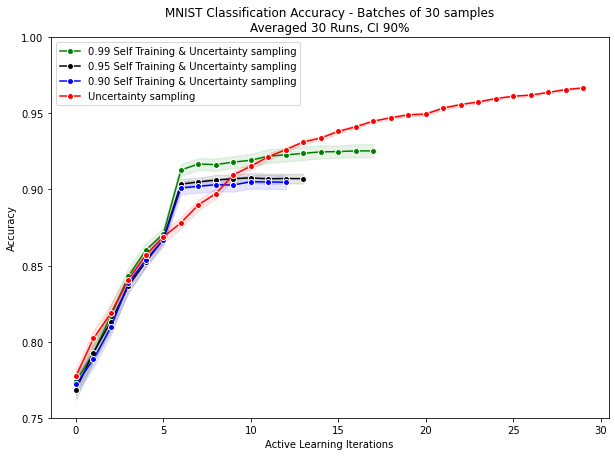

In [17]:
fig = plt.figure(figsize=(10,7))

self_training99_mean = np.mean(uncert_self_training99_metrics, axis=0)
self_training95_mean = np.mean(uncert_self_training95_metrics, axis=0)
self_training90_mean = np.mean(uncert_self_training90_metrics, axis=0)
uncert_mean = np.mean(uncert_metrics2, axis=0)


plt.plot(self_training99_mean, c="green", marker="o", markersize=6, markeredgecolor="white", label="0.99 Self Training & Uncertainty sampling")
plt.plot(self_training95_mean, c="black", marker="o", markersize=6, markeredgecolor="white", label="0.95 Self Training & Uncertainty sampling")
plt.plot(self_training90_mean, c="blue", marker="o", markersize=6, markeredgecolor="white", label="0.90 Self Training & Uncertainty sampling")
plt.plot(uncert_mean, c="red", marker="o", markersize=6, markeredgecolor="white", label="Uncertainty sampling")


zscore_90_confidence = 1.65
self_training99_ci = sem(uncert_self_training99_metrics) * zscore_90_confidence
plt.fill_between(range(len(self_training99_mean)), (self_training99_mean-self_training99_ci), (self_training99_mean+self_training99_ci), color='green', alpha=0.1)
self_training95_ci = sem(uncert_self_training95_metrics) * zscore_90_confidence
plt.fill_between(range(len(self_training95_mean)), (self_training95_mean-self_training95_ci),(self_training95_mean+self_training95_ci), color='black', alpha=0.1)
self_training90_ci = sem(uncert_self_training90_metrics) * zscore_90_confidence
plt.fill_between(range(len(self_training90_mean)), (self_training90_mean-self_training90_ci),(self_training90_mean+self_training90_ci), color='blue', alpha=0.1)
uncert_ci = sem(uncert_metrics2) * zscore_90_confidence
plt.fill_between(range(len(uncert_mean)), (uncert_mean-uncert_ci),(uncert_mean+uncert_ci), color='red', alpha=0.1)


plt.title(f"MNIST Classification Accuracy - Batches of {sample_size} samples\nAveraged {repeat_n} Runs, CI 90%")
plt.ylim((0.75, 1))
plt.xlabel("Active Learning Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.plot()

### Results significance

In [18]:
ranksums(uncert_mean, self_training99_mean, alternative="less")

RanksumsResult(statistic=2.427730946999772, pvalue=0.99240319501127)

In [19]:
ranksums(uncert_mean, self_training95_mean, alternative="less")

RanksumsResult(statistic=3.0993086786756634, pvalue=0.9990301359435485)

In [20]:
ranksums(uncert_mean, self_training90_mean, alternative="less")

RanksumsResult(statistic=3.0939824292854787, pvalue=0.9990125540892157)